In [40]:
import numpy as np
import torch
import torch.nn as nn
from PIL import Image

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png')

In [41]:
# import math
# from tqdm import tqdm
# from torch import Tensor
# from typing import Tuple, List



# def compute_gaussian_density(x: Tuple[float, float], mean: Tuple[float, float], std: Tuple[float, float]):
#     exp_term = torch.exp(-0.5 * (((x[0] - mean[0]) / std[0]) ** 2 + ((x[1] - mean[1]) / std[1]) ** 2))
#     std_term = 1 / (std[0] * std[1])
#     const_term = 1 / (2 * np.pi)
    
#     return exp_term * std_term * const_term


# def d_normal_pdf_d_mu_i(x, mean_x, std_x, density_value):
#     return density_value * (x - mean_x) / (std_x * std_x)

# def d_normal_pdf_d_std_i(x, mean_x, std_x, density_value):
#     d_denom_term = -density_value / std_x
#     d_exp_term = density_value * (x - mean_x) * (x - mean_x) / (std_x * std_x * std_x)
    
#     return d_denom_term + d_exp_term

# x = torch.rand(2)
# means = nn.Parameter(torch.rand(2))
# std = nn.Parameter(torch.rand(2))

# density_val = compute_gaussian_density(x, means, std)

# density_val.backward()

# print(std.grad[0].item())
# print(d_normal_pdf_d_std_i(x[0], means[0], std[0], density_val).item())

In [266]:
import math
from tqdm import tqdm
from torch import Tensor
from typing import Tuple, List


def get_color_bil(x: float, y: float, image: Tensor):
    """
    Selects a color from an image using bilinear interpolation
    """
    i, j = math.floor(y.item()), math.floor(x.item())
    c0 = image[max(i, 0)][max(j, 0)]
    c1 = image[max(i, 0)][min(j+1, image.shape[1] - 1)]
    c2 = image[min(i+1, image.shape[0] - 1)][min(j+1, image.shape[1] - 1)]
    c3 = image[min(i+1, image.shape[0] - 1)][max(j, 0)]
    w_top = y - i
    w_left = x - j
    
    # Step 1: interpolate along x-axis
    color_top = c0 * (1 - w_left) + c1 * w_left
    color_bot = c3 * (1 - w_left) + c2 * w_left
    
    # Step 2: interpolate along y-axis
    color = color_top * (1 - w_top) + w_top * color_bot

    return color


def get_color_nearest(x: float, y: float, image: Tensor):
    i = min(max(round(y.item()), 0), image.shape[0] - 1)
    j = min(max(round(x.item()), 0), image.shape[1] - 1)
    
    return image[i][j]


def compute_gaussian_density(x: Tuple[float, float], mean: Tuple[float, float], std: Tuple[float, float]):
    exp_term = torch.exp(-0.5 * (((x[0] - mean[0]) / std[0]) ** 2 + ((x[1] - mean[1]) / std[1]) ** 2))
    std_term = 1 / (std[0] * std[1])
    const_term = 1 / (2 * np.pi)
    
    return exp_term * std_term * const_term


def gaussian_interpolation(means: Tensor, stds: Tensor, img: Tensor, radius: int):
    """
    Performs a gaussian process interpolation
    means: [num_coords, 2]
    stds: [num_coords, 2]
    images: [image_width, image_height]
    density_threshold --- we do not 
    """
    result = torch.zeros_like(img)
    total_weights = torch.zeros(img.shape[0], img.shape[1])

    for i in tqdm(range(0, len(means))):
        center = (round(means[i][0].item()), round(means[i][1].item()))
        color = get_color_nearest(means[i][0], means[i][1], img)

        for y_shift in range(-radius, radius + 1):
            for x_shift in range(-radius, radius + 1):
                pixel_pos = (center[0] + x_shift, center[1] + y_shift)
                
                if (pixel_pos[0] < 0 or pixel_pos[0] >= img.shape[1]) or (pixel_pos[1] < 0 or pixel_pos[1] >= img.shape[0]):
                    continue

                weight = compute_gaussian_density(pixel_pos, means[i], stds[i])
                #weight = means[i][0] + means[i][1]
                #weight = (1 / ((pixel_pos[0] - means[i][0]) ** 2 + (pixel_pos[1] - means[i][1]) ** 2 + 1e-10)) ** 1
                if weight > 0:
                    result[pixel_pos[1], pixel_pos[0]] += color * weight
                    total_weights[pixel_pos[1], pixel_pos[0]] += weight
    
    # Now, we should normalize the colors by the total weight
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            if total_weights[i][j] > 0:
                result[i][j] /= total_weights[i][j]

    return result, total_weights

100%|██████████| 4/4 [00:00<00:00, 418.80it/s]

tensor(0.1282, grad_fn=<MeanBackward0>)


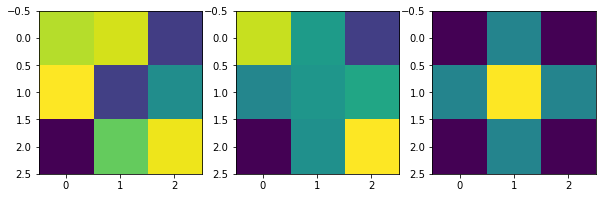

In [297]:
size = w = h = 3
grid_w = grid_h = 2
std_scale = 1.0
img = torch.linspace(1, 0, size).view(-1, 1).repeat(1, size).unsqueeze(2)
torch.manual_seed(42)
img = torch.rand_like(img.permute(2, 0, 1)).permute(1, 2, 0)
mean_x = torch.linspace(0, w - 1, grid_w).unsqueeze(0).repeat(grid_h, 1).float() # [grid_h, grid_w]
mean_y = torch.linspace(0, h - 1, grid_h).unsqueeze(1).repeat(1, grid_w).float() # [grid_h, grid_w]
means = torch.stack([mean_x, mean_y]).permute(1, 2, 0).view(-1, 2) # [num_coords, 2]
# means = torch.tensor([[0.0, 0.0]])
# means = torch.tensor([[1.0, 1.0]])
stds = torch.ones_like(means) * std_scale # [num_coords, 2]
means = nn.Parameter(means)
stds = nn.Parameter(stds)
result, weights = gaussian_interpolation(means, stds, img, 1)
print((result - img).abs().mean())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))

plt.subplot(131)
plt.imshow(img.squeeze(2))

plt.subplot(132)
plt.imshow(result.detach().squeeze(2))

plt.subplot(133)
plt.imshow(weights.detach())

In [298]:
(result - img).abs().mean().backward()

In [299]:
means.grad

tensor([[-0.0065, -0.0100],
        [-0.0074, -0.0220],
        [ 0.0090, -0.0074],
        [ 0.0100, -0.0245]])

In [10]:
import torch.nn as nn
import torchvision.transforms.functional as TVF

img = Image.open('/tmp/skoroki/datasets/ffhq/thumbnails128x128/00000.png').convert('LA')
img = TVF.to_grayscale(img)
img = torch.from_numpy(np.array(img)).unsqueeze(2)
img_size = img.shape[0]
grid_size = img_size // 4
x_coords = torch.linspace(0.0, img_size - 1, grid_size).view(1, -1).repeat(grid_size, 1).float()
means = torch.stack([x_coords, x_coords.t()]).permute(1, 2, 0).view(-1, 2)
stds = torch.ones_like(means) * 1.0

means = nn.Parameter(means)
stds = nn.Parameter(stds)
result, weights = gaussian_interpolation(means, stds, img.float(), 5)
# result = result.permute(2, 0, 1).byte()

100%|██████████| 1024/1024 [00:30<00:00, 33.46it/s]


In [15]:
diff = (result - img.float())
diff.abs().mean()

tensor(8.0624, grad_fn=<MeanBackward0>)

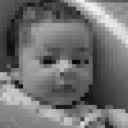

In [14]:
TVF.to_pil_image(result.permute(2, 0, 1).byte())

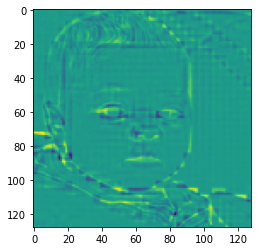

In [13]:
plt.imshow((diff / diff.abs().max() + 1).detach().squeeze(2) * 0.5)

In [247]:
means_adjusted = means - means.grad * 0.5
stds_adjusted = stds - stds.grad * 0.5
result_adjusted, _ = gaussian_interpolation(means_adjusted.detach(), stds_adjusted.detach(), img.float(), 5)

100%|██████████| 1024/1024 [00:22<00:00, 44.53it/s]


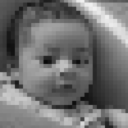

In [248]:
TVF.to_pil_image(result_adjusted.permute(2, 0, 1).byte())

In [266]:
(result_adjusted - img.float()).abs().mean()

tensor(7.5882)

In [10]:
from PIL import Image
import torchvision.transforms.functional as TVF

interps = ['NEAREST', 'BOX', 'BILINEAR', 'HAMMING', 'BICUBIC', 'LANCZOS']
# img_pil = Image.open('../cuda/water.jpg')
img_pil = Image.open('../cuda/room.jpg')
img = TVF.to_tensor(img_pil)
downsample_size = 0.3
downsample_size = round(downsample_size * img.shape[1]), round(downsample_size * img.shape[2])


for interp in range(6):
    downsampled = TVF.resize(img_pil, size=downsample_size, interpolation=2)
    upsampled = TVF.resize(downsampled, size=(img.shape[1], img.shape[2]), interpolation=interp)
    #print(interps[interp], f'{(TVF.to_tensor(upsampled) - img).pow(2).mean().item():.05f}')
    print(interps[interp], f'{(TVF.to_tensor(upsampled) - img).abs().mean().item():.05f}')

NEAREST 0.01511
BOX 0.01266
BILINEAR 0.01448
HAMMING 0.01312
BICUBIC 0.01511
LANCZOS 0.01404


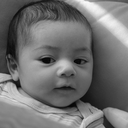

In [252]:
TVF.to_pil_image(img.permute(2, 0, 1))